# CNN Model dla prognozowania cen akcji

Ten notebook implementuje model CNN (1D Convolutional Neural Network) oparty na pliku `cnn_model.py`, który analizuje dane giełdowe identycznie jak LSTM.

## 1. Import bibliotek

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Dodanie katalogu głównego do ścieżki
sys.path.append('..')

from src.cnn_model import TimeSeriesCNN, CNNTrainer, prepare_data_for_cnn
from src.utils import (
    create_directories,
    plot_training_history,
    plot_predictions,
    evaluate_model,
    print_metrics,
    save_model
)

# Styl wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
sns.set_context('talk')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Używane urządzenie: {device}')

create_directories()

Używane urządzenie: cuda
Struktura katalogów utworzona pomyślnie.


## 2. Wczytanie danych

In [5]:
data_path = r"C:\Users\pawli\OneDrive\Pulpit\sieci\Projektowanie_i_zastosowania_sieci_neuronowych\data\data\processed\cleaned_data.csv"

# Jeśli dane nie istnieją, wykonaj preprocessing
if not os.path.exists(data_path):
    from src.data_preprocessing import preprocess
    df = preprocess()
else:
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])

print(f"Liczba wierszy w danych: {len(df)}")
df.head()

Liczba wierszy w danych: 2623


C:\Users\pawli\AppData\Local\Temp\ipykernel_16744\1659203446.py:9: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Open,High,Low,Close/Last,Volume
0,2015-01-02 00:00:00-05:00,172.871019,173.289837,171.028213,172.075256,121465900
1,2015-01-05 00:00:00-05:00,171.019838,171.187362,168.657715,168.967636,169632600
2,2015-01-06 00:00:00-05:00,169.277519,169.805233,166.571964,167.376099,209151400
3,2015-01-07 00:00:00-05:00,168.716328,169.805256,168.264011,169.461823,125346700
4,2015-01-08 00:00:00-05:00,170.885835,172.686757,170.869091,172.468964,147217800


## 3. Przygotowanie danych

In [7]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
target_col = 'Close/Last'
seq_length = 20

data = prepare_data_for_cnn(
    df=df,
    feature_cols=feature_cols,
    target_col=target_col,
    seq_length=seq_length,
    test_size=0.2,
    val_size=0.1,
    batch_size=32,
    shuffle=True
)

print(f"Liczba próbek treningowych: {len(data['X_train'])}")
print(f"Liczba próbek walidacyjnych: {len(data['X_val'])}")
print(f"Liczba próbek testowych: {len(data['X_test'])}")
print(f"Rozmiar danych wejściowych: {data['X_train'].shape}")

ImportError: cannot import name 'create_sequence_data' from 'src.lstm_model' (..\src\lstm_model.py)

## 4. Budowa i trening modelu CNN

In [ ]:
model = TimeSeriesCNN(
    input_channels=data['input_channels'],
    seq_length=data['seq_length']
)

trainer = CNNTrainer(model)

history = trainer.fit(
    train_loader=data['train_loader'],
    val_loader=data['val_loader'],
    epochs=50,
    early_stopping_patience=7
)

Epoka 1/50, Strata treningowa: 0.019534, Strata walidacyjna: 0.030169
Epoka 2/50, Strata treningowa: 0.010630, Strata walidacyjna: 0.049403
Epoka 3/50, Strata treningowa: 0.008861, Strata walidacyjna: 0.015036
Epoka 4/50, Strata treningowa: 0.008174, Strata walidacyjna: 0.023825
Epoka 5/50, Strata treningowa: 0.006276, Strata walidacyjna: 0.013600
Epoka 6/50, Strata treningowa: 0.005826, Strata walidacyjna: 0.021239
Epoka 7/50, Strata treningowa: 0.005642, Strata walidacyjna: 0.030021
Epoka 8/50, Strata treningowa: 0.005297, Strata walidacyjna: 0.011804
Epoka 9/50, Strata treningowa: 0.006140, Strata walidacyjna: 0.022265
Epoka 10/50, Strata treningowa: 0.004165, Strata walidacyjna: 0.013054
Epoka 11/50, Strata treningowa: 0.003666, Strata walidacyjna: 0.015889
Epoka 12/50, Strata treningowa: 0.003970, Strata walidacyjna: 0.024521
Epoka 13/50, Strata treningowa: 0.004058, Strata walidacyjna: 0.037441
Epoka 14/50, Strata treningowa: 0.003581, Strata walidacyjna: 0.023859
Epoka 15/50, St

..\src\cnn_model.py:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('models/cnn/best_model.pth'))


## 5. Predykcja i wizualizacja wyników

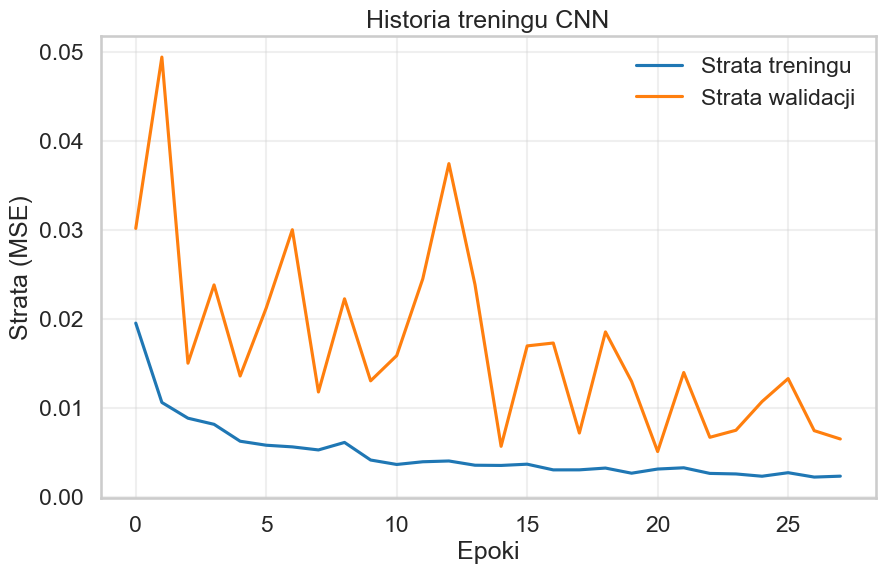

NameError: name 'y_pred' is not defined

In [ ]:
from IPython.display import display

fig1 = plot_training_history(history, title="Historia treningu CNN")
display(fig1)

fig2 = plot_predictions(data['y_test'], y_pred, scaler=data['target_scaler'], title="Predykcja CNN vs Rzeczywiste")
display(fig2)


## 6. Ewaluacja modelu

In [ ]:
metrics = evaluate_model(data['y_test'], y_pred, scaler=data['target_scaler'])
print_metrics(metrics)


=== Metryki wydajności modelu ===
MSE: 3099.480849
RMSE: 55.672981
MAE: 49.828216
R²: -1.219826
